In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [65]:
df = pd.read_csv('../sentiment_analysis/Reviews.csv')

In [66]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [67]:
# lets reduce our data to 500 Rows to avoid dealing with large dataset
df.shape

(568454, 10)

In [68]:
df = df.head(500)
df.shape

(500, 10)

## Quick EDA (Exploratary Data Aaylysis)

In [69]:
df_EDA=df['Score'].value_counts().sort_index()
df_EDA

Score
1     36
2     18
3     37
4     70
5    339
Name: count, dtype: int64

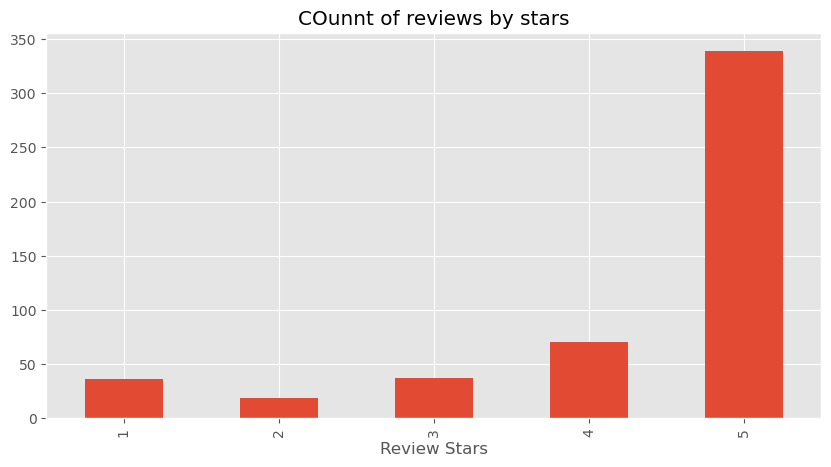

In [70]:

df_EDA.plot(kind='bar', title='COunnt of reviews by stars',
           figsize=(10,5))
plt.xlabel('Review Stars')
plt.show()

## Basic NLTK 

In [71]:
example = df['Text'][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [72]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [73]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [74]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [Errno 11001] getaddrinfo failed>


False

In [75]:
# part of speech for each of these tokes (POS)
tagged=nltk.pos_tag(tokens)
tagged[:10]
# there is a page that cotais the differet POS meaning(i.e NN- a singular noun,)

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [76]:
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Error loading maxent_ne_chunker_tab: <urlopen error [Errno
[nltk_data]     11001] getaddrinfo failed>


False

In [77]:
nltk.download('words')

[nltk_data] Error loading words: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# putting these tagged into entities
entities= nltk.chunk.ne_chunk(tagged)
entities.pprint()

## now lets begin

## Step 1: VADER sentiment scoring
we will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.
This uses a "bag of words" approach:
1. Stop words are removed(And, or etc because they really do not have any emotions t them)
2. each word is scored and combined to the total score

In [78]:
nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [79]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [80]:
sia.polarity_scores('i am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [81]:
sia.polarity_scores('today is the worst day ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [82]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [83]:
# run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid=row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [84]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how='left')

In [85]:
# ow we have setimet score ad metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

In [86]:
import seaborn as sns

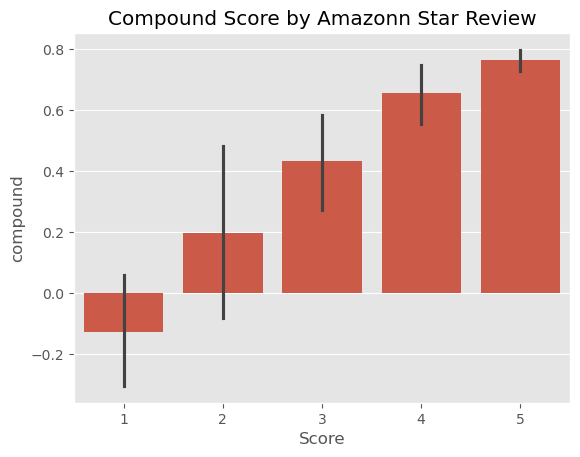

In [87]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazonn Star Review')
plt.show()

<Axes: xlabel='Score', ylabel='pos'>

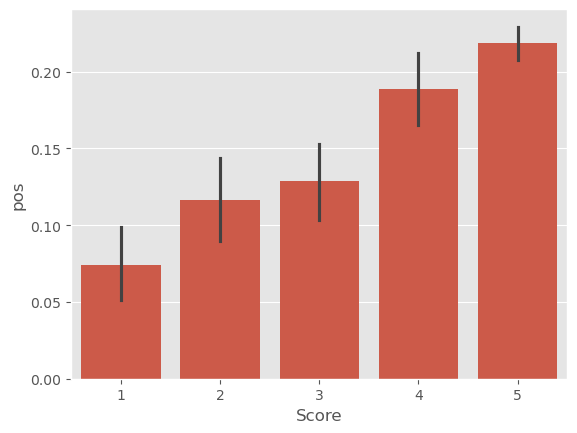

In [88]:
# TO look at the pos, eg ad neutral scores of each
sns.barplot(data=vaders, x = 'Score', y='pos')

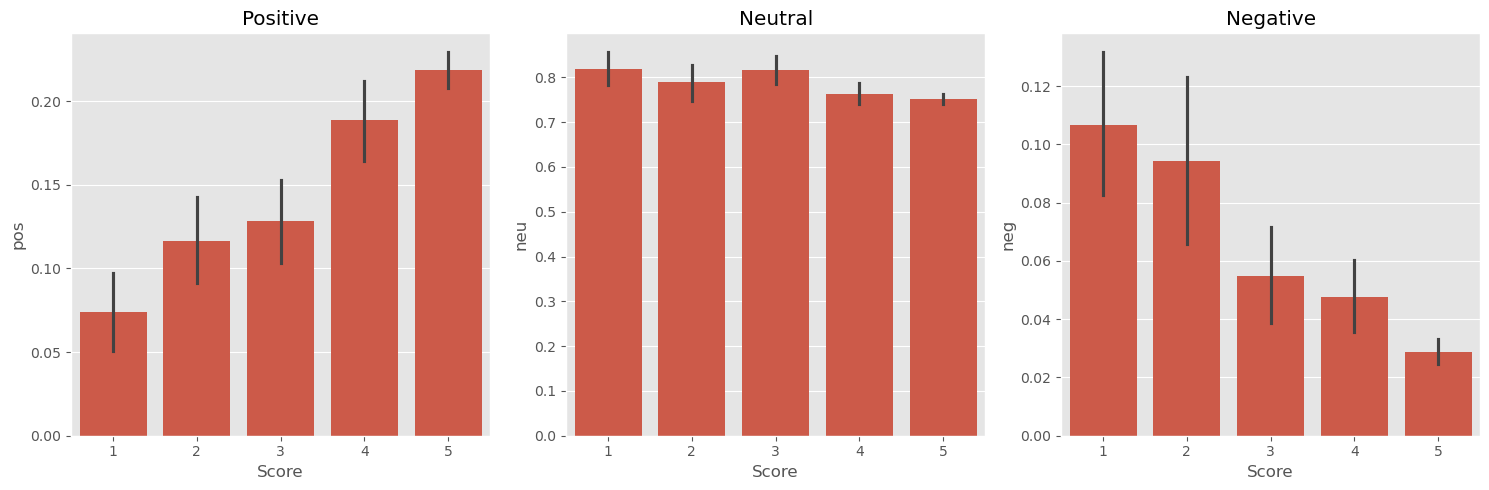

In [89]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

As the star review gets higher, the comments tends to be more positive, neutral comments varry while negative comments tends to decrease significantly

**human language depends on context(if its a sacarsm, the tone i which it is said)** 

### Step 3. Roberta Pretrained Model

* use a model trained of a large corpus of data.
* Transformer model accounts for the words ut also the context related to other words

In [90]:
!pip install transformers

In [91]:
!pip install transformers

In [92]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [93]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [94]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch.nn.functional as F
import numpy as np

In [95]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [96]:
# VADER results o example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [97]:
# Run for Roerta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
# chage it to umpy so we ca store it locally
scores = output[0][0].detach().numpy()
scores = softmax(scores)
# make a score dictionary where we can store this
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos': scores[2]
}
scores_dict


{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687465,
 'roberta_pos': 0.0029573678}

In [98]:
# lets run this on the full data
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    # chage it to umpy so we ca store it locally
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    # make a score dictionary where we can store this
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [99]:
# run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        
        text = row['Text']
        myid=row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"]=value

        roberta_result = polarity_scores_roberta(text)
        # add the 2 dictionaries together
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f"broke for id {myid}")


    

  0%|          | 0/500 [00:00<?, ?it/s]

broke for id 83
broke for id 187


In [100]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [101]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare scores betweeen models

In [102]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

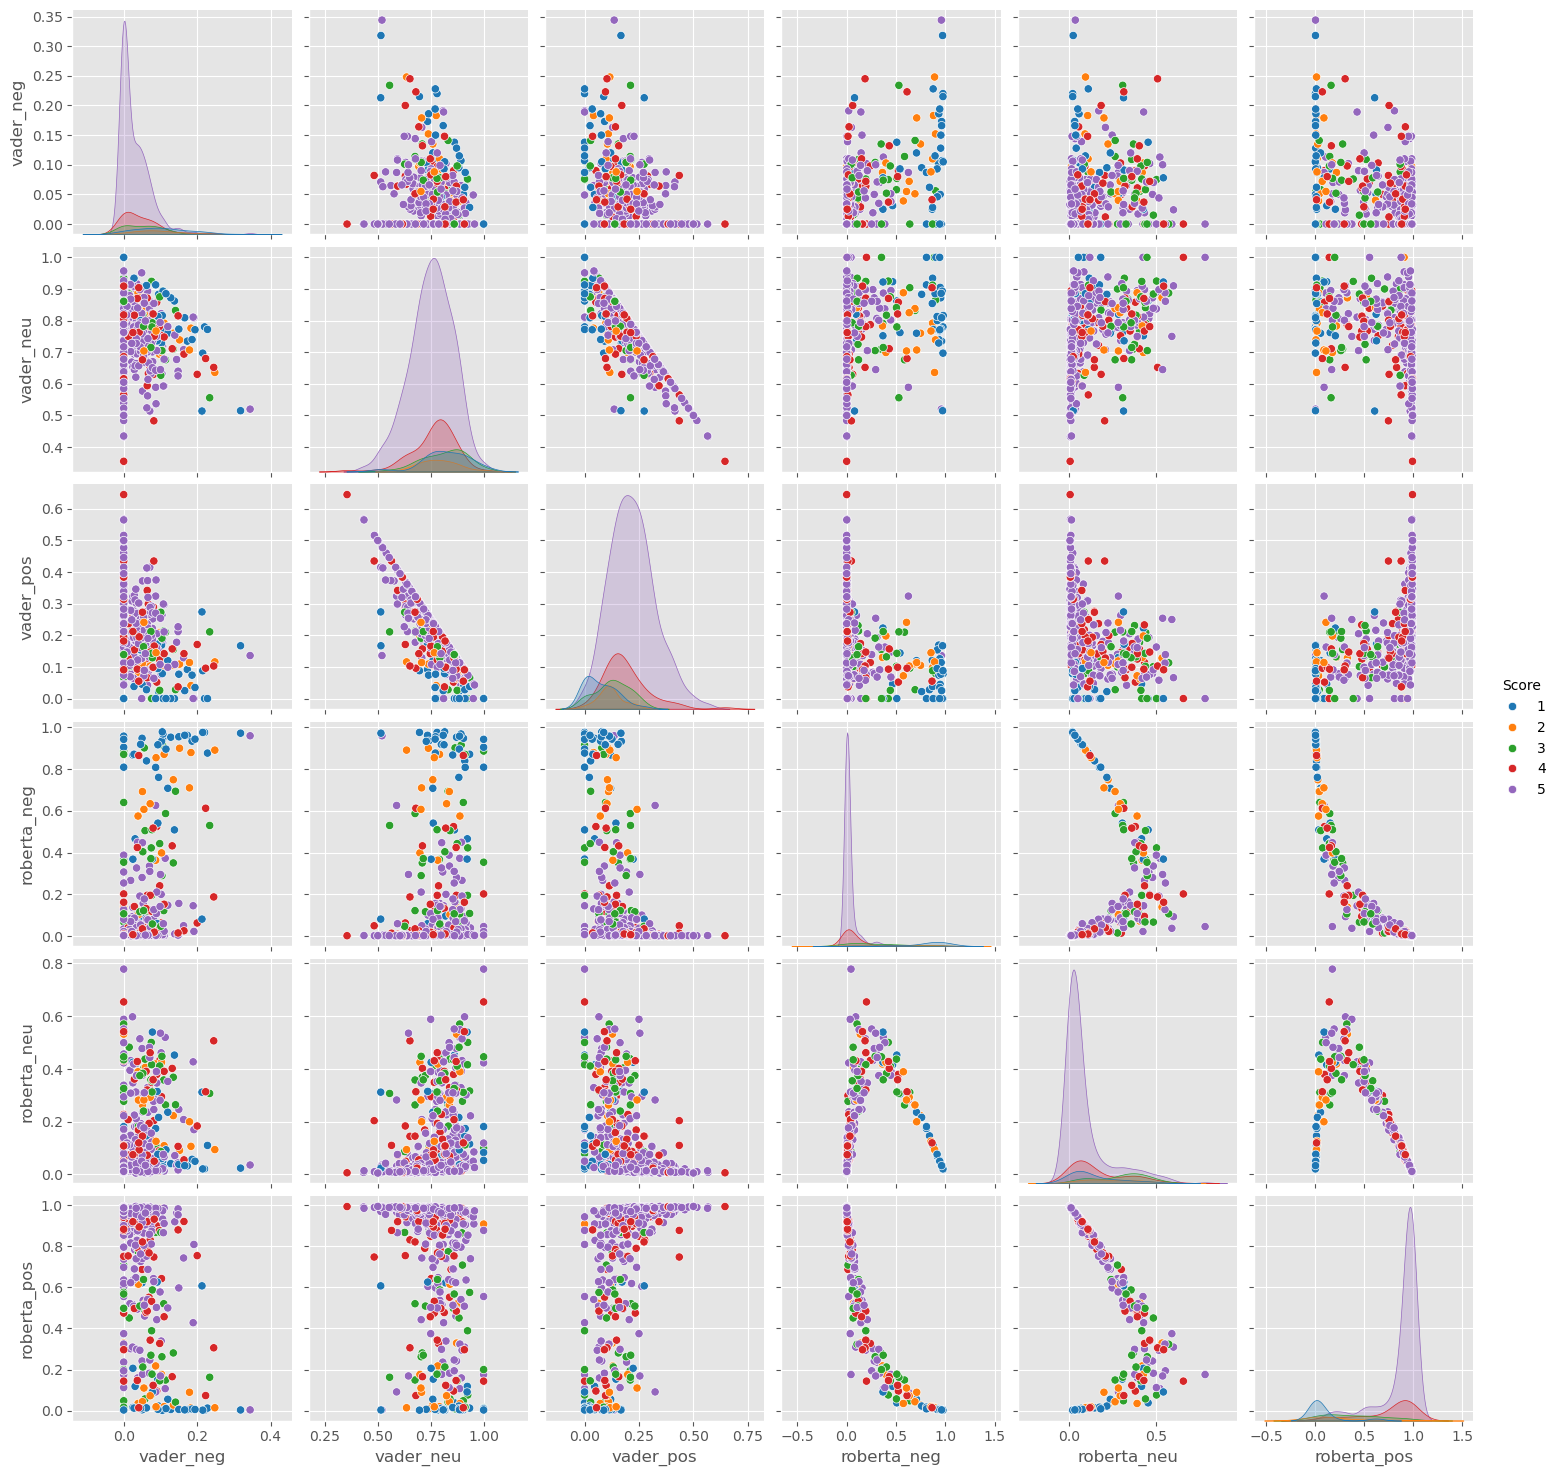

In [103]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Review Examples

* positive 1-star and negative 5-star Reviews

lets look at some examples where the model scoring and review score differ the most

In [104]:
results_df.query('Score ==1') \
    .sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [105]:
results_df.query('Score ==1') \
    .sort_values('vader_pos',ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [106]:
results_df.query('Score ==5') \
    .sort_values('roberta_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [107]:
results_df.query('Score ==5') \
    .sort_values('vader_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'